# Phase 3 & 4: Pattern Identification (Clustering) and Statistical Validation

This notebook covers:
- **Phase 3**: K-Means clustering as an exploratory data analysis technique to identify behavioral patterns
- **Phase 4**: Statistical validation using ANOVA to test if identified patterns significantly differ
- **Focus**: Using clustering as a tool for pattern discovery, not predictive modeling

In [31]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy import stats
from scipy.stats import f_oneway
import json
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Load Processed Data

In [32]:
# Load cleaned data and scaled features
df = pd.read_csv('data/cleaned_data.csv')
X_scaled = pd.read_csv('data/scaled_features.csv')

# Load metadata
with open('data/metadata.json', 'r') as f:
    metadata = json.load(f)

clustering_features = metadata['clustering_features']
targets = metadata['targets']

print(f"Loaded {len(df)} samples")
print(f"Clustering features: {clustering_features}")
print(f"Targets: {targets}")

# Convert to numpy array for sklearn
X_scaled_array = X_scaled.values

Loaded 81 samples
Clustering features: ['Sleep_Hours', 'Music_Time_Hours', 'Travel Time (Hours)', 'Work_Hours', 'Study_Hours', 'Chore_Time_Mins', 'Distraction_Time_Mins', 'Tasks_Completed']
Targets: ['Mood_Rating', 'Focus_Rating']


## Phase 3.1: Elbow Method / Silhouette Analysis

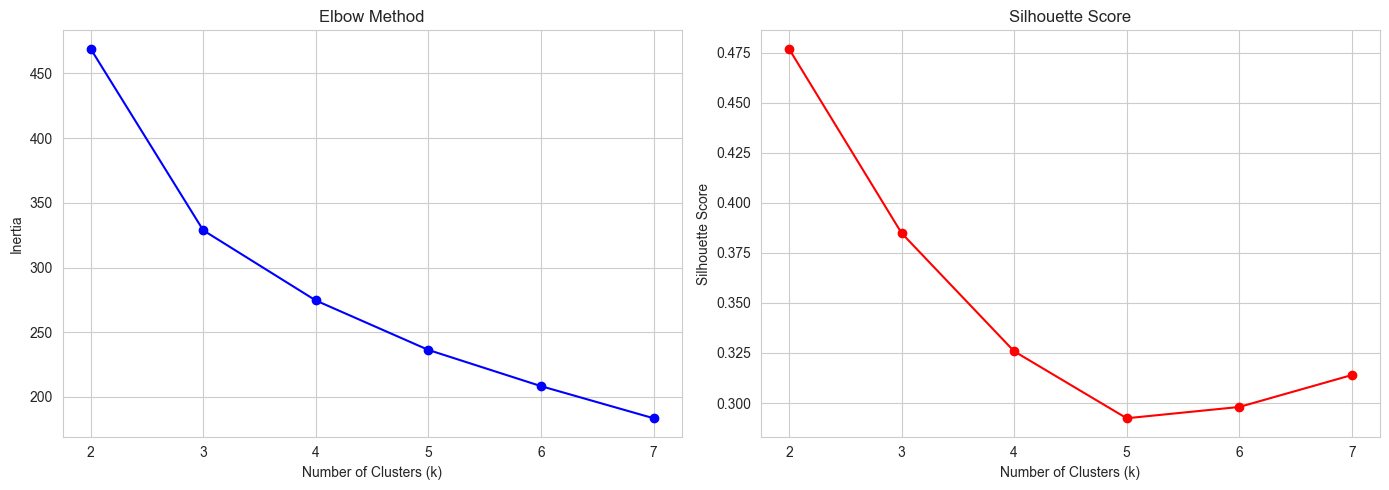

Silhouette Scores:
  k=2: 0.4768
  k=3: 0.3849
  k=4: 0.3259
  k=5: 0.2924
  k=6: 0.2981
  k=7: 0.3140

Using k=3 (as per methodology)


In [33]:
# Elbow Method and Silhouette Score for k selection
k_range = range(2, 8)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_array)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_array, kmeans.labels_))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

# Silhouette plot
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print scores
print("Silhouette Scores:")
for k, score in zip(k_range, silhouette_scores):
    print(f"  k={k}: {score:.4f}")

# Methodology suggests k=3, validate this choice
optimal_k = 3
print(f"\nUsing k={optimal_k} (as per methodology)")

## Phase 3.2: Fit K-Means (k=3)

In [34]:
# Fit K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled_array)

# Add cluster labels to dataframe
df['KMeans_Cluster'] = kmeans_labels

print(f"K-Means clustering completed with k=3")
print(f"Cluster distribution:")
print(df['KMeans_Cluster'].value_counts().sort_index())

K-Means clustering completed with k=3
Cluster distribution:
KMeans_Cluster
0    52
1     7
2    22
Name: count, dtype: int64


## Phase 3.3: Cluster Profiling

In [35]:
# Compute mean and std of each feature per cluster
cluster_profiles = df.groupby('KMeans_Cluster')[clustering_features + targets].agg(['mean', 'std'])

print("Cluster Profiles (Mean ± Std):")
print(cluster_profiles)

# Name clusters based on characteristics (per methodology)
cluster_names = {
    0: "The Commuter Grind",
    1: "The Deep Work / WFH Day",
    2: "The Distracted Recovery"
}

print("\n" + "="*80)
print("Cluster Characteristics:")
print("="*80)

for cluster_id in sorted(df['KMeans_Cluster'].unique()):
    cluster_data = df[df['KMeans_Cluster'] == cluster_id]
    print(f"\n{cluster_names[cluster_id]} (Cluster {cluster_id}):")
    print(f"  Count: {len(cluster_data)} days")
    print(f"  Travel Time: {cluster_data['Travel Time (Hours)'].mean():.2f} ± {cluster_data['Travel Time (Hours)'].std():.2f} hours")
    print(f"  Work Hours: {cluster_data['Work_Hours'].mean():.2f} ± {cluster_data['Work_Hours'].std():.2f} hours")
    print(f"  Study Hours: {cluster_data['Study_Hours'].mean():.2f} ± {cluster_data['Study_Hours'].std():.2f} hours")
    print(f"  Distraction Time: {cluster_data['Distraction_Time_Mins'].mean():.2f} ± {cluster_data['Distraction_Time_Mins'].std():.2f} mins")
    print(f"  Sleep Hours: {cluster_data['Sleep_Hours'].mean():.2f} ± {cluster_data['Sleep_Hours'].std():.2f} hours")
    print(f"  Tasks Completed: {cluster_data['Tasks_Completed'].mean():.2f} ± {cluster_data['Tasks_Completed'].std():.2f}")
    print(f"  Mood Rating: {cluster_data['Mood_Rating'].mean():.2f} ± {cluster_data['Mood_Rating'].std():.2f}")
    print(f"  Focus Rating: {cluster_data['Focus_Rating'].mean():.2f} ± {cluster_data['Focus_Rating'].std():.2f}")

Cluster Profiles (Mean ± Std):
               Sleep_Hours           Music_Time_Hours            \
                      mean       std             mean       std   
KMeans_Cluster                                                    
0                 6.259615  0.915500         4.000000  2.151151   
1                 0.000000  0.000000         0.000000  0.000000   
2                 8.409091  2.771609         6.590909  3.581156   

               Travel Time (Hours)           Work_Hours           Study_Hours  \
                              mean       std       mean       std        mean   
KMeans_Cluster                                                                  
0                         1.798077  0.758156   6.807692  1.836861    4.587179   
1                         0.000000  0.000000   0.000000  0.000000    0.000000   
2                         1.731818  0.768819   0.545455  0.738549    4.617424   

                         Chore_Time_Mins             Distraction_Time_Mins  \
 

## Phase 3.4: Visualizations

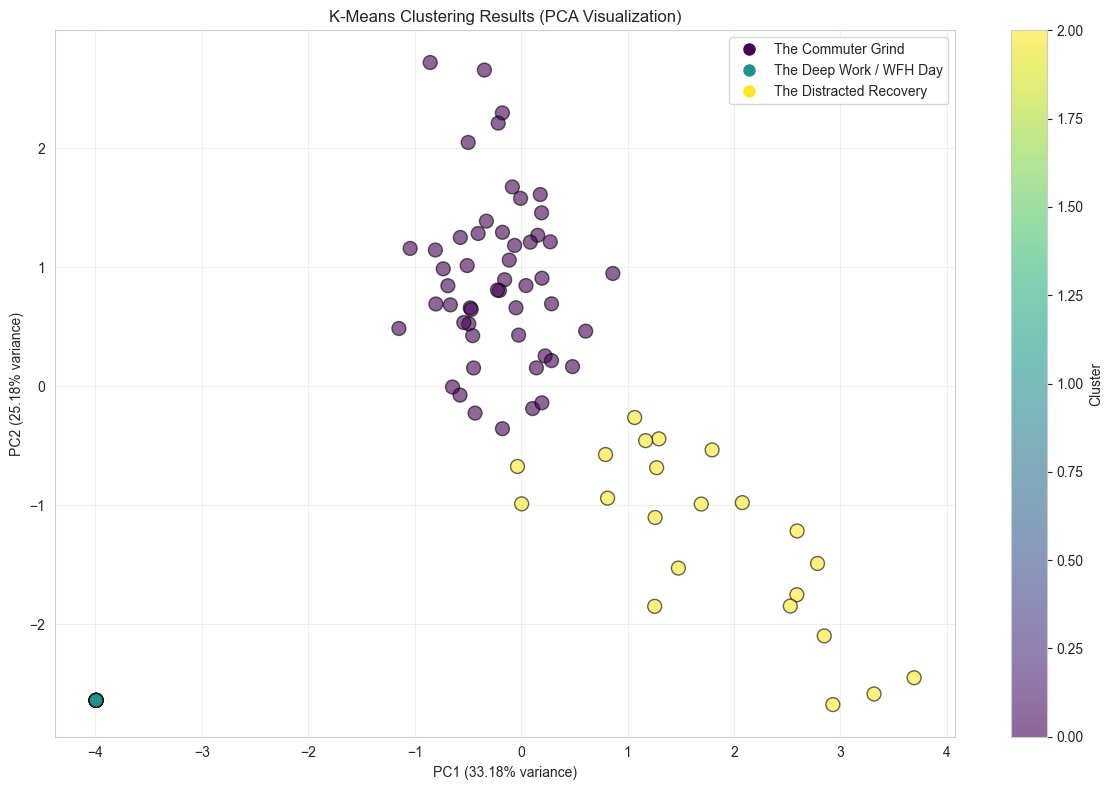

In [36]:
# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_array)

# Create PCA dataframe
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels
pca_df['Cluster_Name'] = pca_df['Cluster'].map(cluster_names)

# Plot PCA scatter
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], 
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('K-Means Clustering Results (PCA Visualization)')
plt.colorbar(scatter, label='Cluster')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                               markerfacecolor=plt.cm.viridis(i/2), 
                               markersize=10, label=cluster_names[i]) 
                    for i in range(3)])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

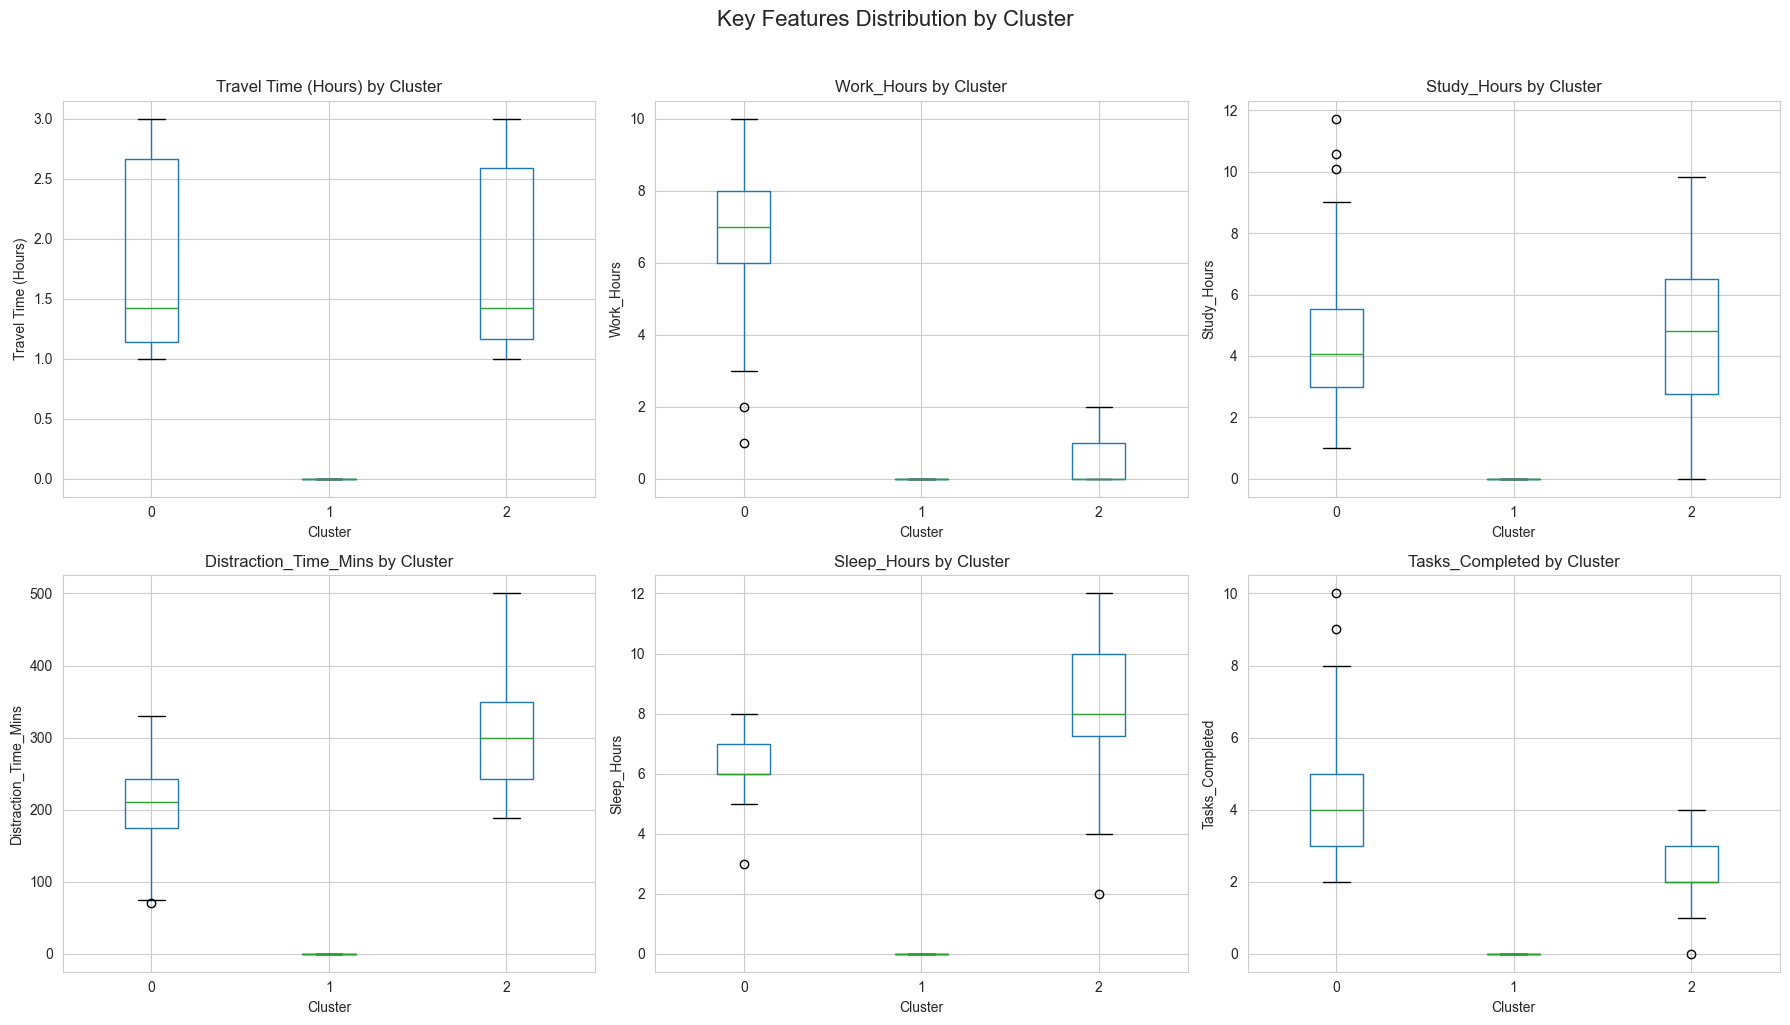

In [37]:
# Box plots of key features by cluster
key_features = ['Travel Time (Hours)', 'Work_Hours', 'Study_Hours', 
                'Distraction_Time_Mins', 'Sleep_Hours', 'Tasks_Completed']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    df.boxplot(column=feature, by='KMeans_Cluster', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Cluster')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(feature)

plt.suptitle('Key Features Distribution by Cluster', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

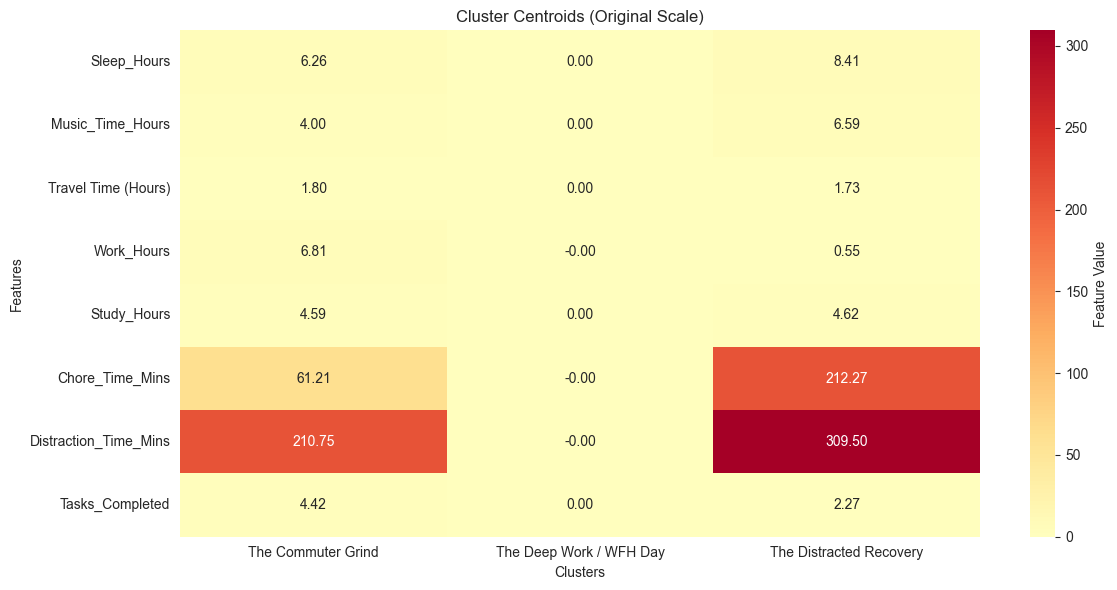

In [38]:
# Heatmap of cluster centroids (scaled back for interpretability)
# Get centroids and inverse transform
centroids_scaled = kmeans.cluster_centers_
scaler = StandardScaler()
scaler.fit(df[clustering_features])
centroids_original = scaler.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids_original, 
                           columns=clustering_features,
                           index=[cluster_names[i] for i in range(3)])

plt.figure(figsize=(12, 6))
sns.heatmap(centroids_df.T, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0, cbar_kws={'label': 'Feature Value'})
plt.title('Cluster Centroids (Original Scale)')
plt.ylabel('Features')
plt.xlabel('Clusters')
plt.tight_layout()
plt.show()

## Phase 3.5: Comparative Clustering Analysis

In [39]:
# Fit alternative clustering algorithms
k = 3

# Hierarchical Clustering (Agglomerative)
hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled_array)
df['Hierarchical_Cluster'] = hierarchical_labels

# DBSCAN (tune eps and min_samples to get ~3 clusters)
# Try different eps values
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
best_eps = None
best_n_clusters = 0

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=3)
    dbscan_labels = dbscan.fit_predict(X_scaled_array)
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    if abs(n_clusters - k) < abs(best_n_clusters - k):
        best_eps = eps
        best_n_clusters = n_clusters

dbscan = DBSCAN(eps=best_eps, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_scaled_array)
df['DBSCAN_Cluster'] = dbscan_labels
print(f"DBSCAN: eps={best_eps}, n_clusters={best_n_clusters}, noise points={(dbscan_labels == -1).sum()}")

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=k, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled_array)
df['GMM_Cluster'] = gmm_labels

print("\nAll clustering algorithms fitted!")

DBSCAN: eps=1.0, n_clusters=4, noise points=52

All clustering algorithms fitted!


In [40]:
# Compute internal metrics for each algorithm
algorithms = {
    'K-Means': kmeans_labels,
    'Hierarchical': hierarchical_labels,
    'DBSCAN': dbscan_labels,
    'GMM': gmm_labels
}

comparison_results = []

for name, labels in algorithms.items():
    # Skip DBSCAN if too many noise points
    if name == 'DBSCAN' and (labels == -1).sum() > len(labels) * 0.5:
        continue
    
    # Filter out noise points for DBSCAN metrics
    if name == 'DBSCAN':
        mask = labels != -1
        if mask.sum() < 3:  # Need at least 3 points
            continue
        X_filtered = X_scaled_array[mask]
        labels_filtered = labels[mask]
        silhouette = silhouette_score(X_filtered, labels_filtered)
        ch_score = calinski_harabasz_score(X_filtered, labels_filtered)
    else:
        silhouette = silhouette_score(X_scaled_array, labels)
        ch_score = calinski_harabasz_score(X_scaled_array, labels)
    
    comparison_results.append({
        'Algorithm': name,
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Index': ch_score
    })

comparison_df = pd.DataFrame(comparison_results)
print("Internal Metrics Comparison:")
print(comparison_df.to_string(index=False))

Internal Metrics Comparison:
   Algorithm  Silhouette Score  Calinski-Harabasz Index
     K-Means          0.384861                37.879485
Hierarchical          0.377363                37.571921
         GMM          0.156194                14.683217


## Phase 4: Statistical Validation (ANOVA)

### Phase 4.1: Mood vs. Cluster

ANOVA Results: Mood_Rating vs K-Means Cluster
F-statistic: 32.6025
P-value: 0.0000

Interpretation: Significant difference in mood across clusters (α=0.05)


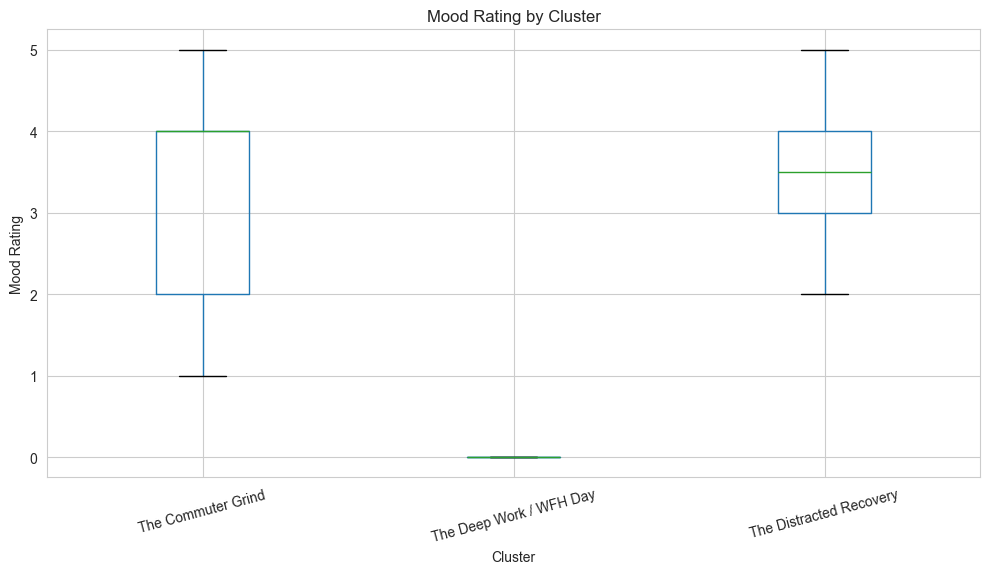

In [41]:
# One-way ANOVA: Mood_Rating by K-Means cluster
cluster_groups = [df[df['KMeans_Cluster'] == i]['Mood_Rating'].values 
                  for i in range(3)]

f_statistic_mood, p_value_mood = f_oneway(*cluster_groups)

print("ANOVA Results: Mood_Rating vs K-Means Cluster")
print("="*60)
print(f"F-statistic: {f_statistic_mood:.4f}")
print(f"P-value: {p_value_mood:.4f}")
print(f"\nInterpretation: {'Significant' if p_value_mood < 0.05 else 'Not significant'} difference in mood across clusters (α=0.05)")

# Box plot
plt.figure(figsize=(10, 6))
df.boxplot(column='Mood_Rating', by='KMeans_Cluster', ax=plt.gca())
plt.title('Mood Rating by Cluster')
plt.suptitle('')  # Remove default title
plt.xlabel('Cluster')
plt.ylabel('Mood Rating')
plt.xticks([1, 2, 3], [cluster_names[i] for i in range(3)], rotation=15)
plt.tight_layout()
plt.show()

### Phase 4.2: Focus vs. Cluster

ANOVA Results: Focus_Rating vs K-Means Cluster
F-statistic: 21.4032
P-value: 0.0000

Interpretation: Significant difference in focus across clusters (α=0.05)


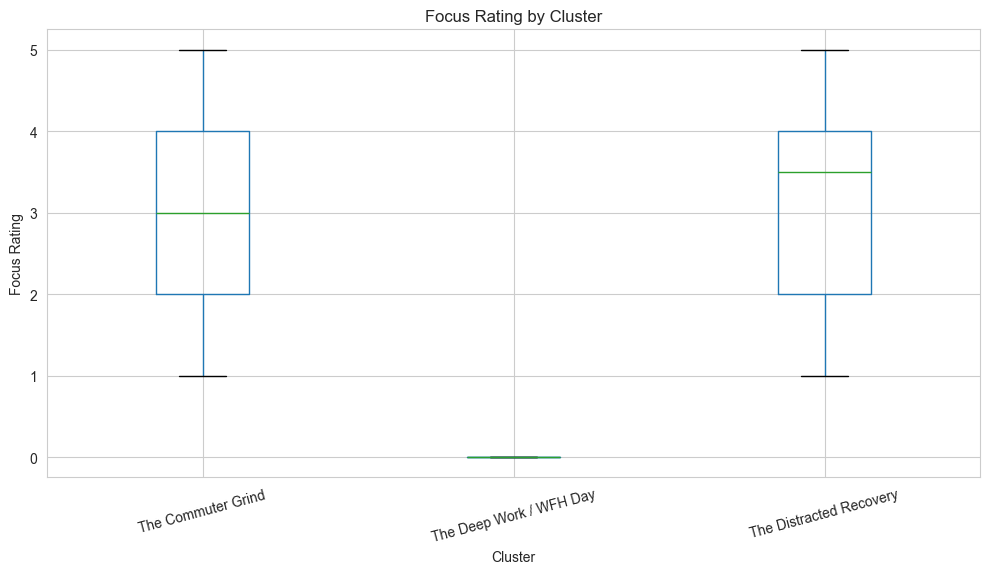

In [42]:
# One-way ANOVA: Focus_Rating by K-Means cluster
cluster_groups_focus = [df[df['KMeans_Cluster'] == i]['Focus_Rating'].values 
                        for i in range(3)]

f_statistic_focus, p_value_focus = f_oneway(*cluster_groups_focus)

print("ANOVA Results: Focus_Rating vs K-Means Cluster")
print("="*60)
print(f"F-statistic: {f_statistic_focus:.4f}")
print(f"P-value: {p_value_focus:.4f}")
print(f"\nInterpretation: {'Significant' if p_value_focus < 0.05 else 'Not significant'} difference in focus across clusters (α=0.05)")

# Box plot
plt.figure(figsize=(10, 6))
df.boxplot(column='Focus_Rating', by='KMeans_Cluster', ax=plt.gca())
plt.title('Focus Rating by Cluster')
plt.suptitle('')  # Remove default title
plt.xlabel('Cluster')
plt.ylabel('Focus Rating')
plt.xticks([1, 2, 3], [cluster_names[i] for i in range(3)], rotation=15)
plt.tight_layout()
plt.show()

### Phase 4.3: ANOVA Comparison Across All Algorithms

In [43]:
# Run ANOVA for all algorithms
anova_results = []

for name, labels in algorithms.items():
    if name == 'DBSCAN' and (labels == -1).sum() > len(labels) * 0.5:
        continue
    
    # Filter noise for DBSCAN
    if name == 'DBSCAN':
        mask = labels != -1
        if mask.sum() < 3:
            continue
        df_filtered = df[mask].copy()
        labels_filtered = labels[mask]
        unique_labels = sorted([l for l in set(labels_filtered) if l != -1])
        if len(unique_labels) < 2:
            continue
        groups_mood = [df_filtered[labels_filtered == i]['Mood_Rating'].values 
                      for i in unique_labels]
        groups_focus = [df_filtered[labels_filtered == i]['Focus_Rating'].values 
                        for i in unique_labels]
    else:
        unique_labels = sorted(set(labels))
        groups_mood = [df[labels == i]['Mood_Rating'].values for i in unique_labels]
        groups_focus = [df[labels == i]['Focus_Rating'].values for i in unique_labels]
    
    if len(groups_mood) >= 2 and all(len(g) > 0 for g in groups_mood):
        f_mood, p_mood = f_oneway(*groups_mood)
    else:
        f_mood, p_mood = np.nan, np.nan
    
    if len(groups_focus) >= 2 and all(len(g) > 0 for g in groups_focus):
        f_focus, p_focus = f_oneway(*groups_focus)
    else:
        f_focus, p_focus = np.nan, np.nan
    
    anova_results.append({
        'Algorithm': name,
        'ANOVA Mood F-stat': f_mood,
        'ANOVA Mood p-value': p_mood,
        'ANOVA Focus F-stat': f_focus,
        'ANOVA Focus p-value': p_focus
    })

anova_comparison = pd.DataFrame(anova_results)
print("ANOVA Results Comparison:")
print(anova_comparison.to_string(index=False))

ANOVA Results Comparison:
   Algorithm  ANOVA Mood F-stat  ANOVA Mood p-value  ANOVA Focus F-stat  ANOVA Focus p-value
     K-Means          32.602508        5.120574e-11           21.403236         3.891990e-08
Hierarchical          32.683500        4.899715e-11           21.326502         4.089799e-08
         GMM           5.933470        3.992927e-03            5.278903         7.076889e-03


### Phase 4.4: Post-hoc Tests (if ANOVA significant)

In [44]:
# Post-hoc tests using pairwise t-tests (if ANOVA is significant)
from itertools import combinations
from scipy.stats import ttest_ind

if p_value_mood < 0.05:
    print("Post-hoc Tests for Mood_Rating (K-Means):")
    print("="*60)
    for i, j in combinations(range(3), 2):
        group_i = df[df['KMeans_Cluster'] == i]['Mood_Rating']
        group_j = df[df['KMeans_Cluster'] == j]['Mood_Rating']
        t_stat, p_val = ttest_ind(group_i, group_j)
        print(f"Cluster {i} vs Cluster {j}: t={t_stat:.4f}, p={p_val:.4f} {'*' if p_val < 0.05 else ''}")
else:
    print("ANOVA for Mood_Rating not significant, skipping post-hoc tests.")

print("\n" + "="*60)

if p_value_focus < 0.05:
    print("Post-hoc Tests for Focus_Rating (K-Means):")
    print("="*60)
    for i, j in combinations(range(3), 2):
        group_i = df[df['KMeans_Cluster'] == i]['Focus_Rating']
        group_j = df[df['KMeans_Cluster'] == j]['Focus_Rating']
        t_stat, p_val = ttest_ind(group_i, group_j)
        print(f"Cluster {i} vs Cluster {j}: t={t_stat:.4f}, p={p_val:.4f} {'*' if p_val < 0.05 else ''}")
else:
    print("ANOVA for Focus_Rating not significant, skipping post-hoc tests.")

Post-hoc Tests for Mood_Rating (K-Means):
Cluster 0 vs Cluster 1: t=7.8603, p=0.0000 *
Cluster 0 vs Cluster 2: t=-0.1106, p=0.9123 
Cluster 1 vs Cluster 2: t=-8.5412, p=0.0000 *

Post-hoc Tests for Focus_Rating (K-Means):
Cluster 0 vs Cluster 1: t=6.3633, p=0.0000 *
Cluster 0 vs Cluster 2: t=-0.3037, p=0.7622 
Cluster 1 vs Cluster 2: t=-6.8885, p=0.0000 *


## Save Results

In [45]:
# Save dataframe with cluster labels
df.to_csv('data/data_with_clusters.csv', index=False)

# Save comparison results
comparison_df.to_csv('data/clustering_comparison.csv', index=False)
anova_comparison.to_csv('data/anova_comparison.csv', index=False)

print("Results saved:")
print("- data/data_with_clusters.csv")
print("- data/clustering_comparison.csv")
print("- data/anova_comparison.csv")

Results saved:
- data/data_with_clusters.csv
- data/clustering_comparison.csv
- data/anova_comparison.csv
